In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.stats
#import seaborn as sns
#sns.set(style="whitegrid")
import time
import seaborn as sns; sns.set()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy
import random

# Functions

In [160]:
def Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn):
    scale_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        scale_ext[r,:eff_date] = sigma_adjust1[r]*np.ones(int(eff_date))
        scale_ext[r,eff_date:] = d*sigma_adjust2[r]*np.ones(int(nn - eff_date))
    return scale_ext

In [161]:
def C_series(eff_dates,pr1,pr2,nn):
    C_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        C_ext[r,:eff_date] = pr1*np.ones(int(eff_date))
        C_ext[r,eff_date:] = pr2*np.ones(int(nn - eff_date))
    return C_ext

In [162]:

def SEIR_Policy_on_off_back(init_vals, C_, Sigma_, p,f, params, d, eff_dates,sigma_adjust1,sigma_adjust2,thresholds1,thresholds2,relax,control_last,last_bf_stop,nn):
    ## input
    # nn is the number of days
    #S_0,E_0,I_0,R_0: dimension: A*R
    # C is a matrix in dimension R*R with compotnent c_(r,r')
    # p is vector in dimension A with each column equals to p_a
    S_0, E_0, I_0, A_0, D_0,R_0 = init_vals
    
    N_A, N_K = S_0.shape[0], S_0.shape[1]
      
    S, E, I, A, D, R = [S_0], [E_0], [I_0], [A_0], [D_0],[R_0]
    C_dynamics = []
    # N: total number of people in each class: matrix dimension A*R
    N = S_0 + E_0 + I_0 + R_0 +D_0+ A_0
    S_i, E_i, I_i, A_i, D_i, R_i = S_0.copy(), E_0.copy(), I_0.copy(), A_0.copy(), D_0.copy(),R_0.copy()
    alpha, beta, gamma, kappa,pi  = params
    Sigma = Sigma_
    C = C_
    
    ### time-dependent parameters
    scale_ts = Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn)
    C_ts = C_series(eff_dates,1.0,0.2,nn)
    
    total_contact = 0
    regional_real_cases = np.zeros((nn+1,N_A,N_K))
    regional_confirm_cases = np.zeros((nn+1,N_A,N_K))
    england_real_cases = np.zeros((nn+1,N_A))
    england_confirm_cases = np.zeros((nn+1,N_A))
    
    regional_real_cases[0,:,] = I_0
    england_real_cases[0] = np.sum(I_0)
    for region in range(N_K):
            for age in range(N_A):
                number = I_0[age,region]
                regional_confirm_cases[0,age,region] =  np.random.binomial(number, pi, 1)[0] 
    england_confirm_cases[0,:] = np.sum(regional_confirm_cases[0,:,:],axis=1)
    
    # signal==0 means relax policy (not control)
    # signal > 0 means control
    signal = np.ones(N_K) 
    signals = np.zeros((N_K,nn+1))
    signals[:,0] = 1
    consecutive_pointer = np.ones(N_K)*last_bf_stop
    for t in range(nn):
        day_contact = 0
        Lambda = np.zeros((N_A,N_K))
        
        C_t = C_.copy()
        for r in range(N_K):
            if signal[r] == 0:
                C_ts_tmp = relax #np.min([1,relax*C_ts[r,t]])
                C_t[r,:] = C_ts_tmp*C_[r,:] + (1-C_ts_tmp)*np.identity(133)[r,:]
                C_t[:,r] = C_ts_tmp*C_[:,r] + (1-C_ts_tmp)*np.identity(133)[:,r]
        
            if signal[r] > 0:
                C_t[r,:] = C_ts[r,t]*C_[r,:] + (1-C_ts[r,t])*np.identity(133)[r,:]
                C_t[:,r] = C_ts[r,t]*C_[:,r] + (1-C_ts[r,t])*np.identity(133)[:,r]
        
        for r in range(N_K):
            if signal[r] > 0:
                #C_r = C_ts[r,t]*C_ + (1-C_ts[r,t])*np.identity(133)
                for a in range(N_A):
                    for a_prime in [0,1,2,3,12,13,14,15]:
                        Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                    for a_prime in [4,5,6,7,8,9,10,11]:
                        Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * ((C_t[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                    day_contact  +=  N[a,r] *scale_ts[r,t] *np.sum(Sigma[a,:])
            if signal[r] ==0 :
               # C_ts_tmp = np.min([1,relax*C_ts[r,t]])
               # C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(133)
                scale_ts_tmp = relax*sigma_adjust1[r] + (1-relax)*scale_ts[r,t] #np.min([sigma_adjust1[r],relax*scale_ts[r,t]])
                for a in range(N_A):
                    for a_prime in [0,1,2,3,12,13,14,15]:
                        Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                    for a_prime in [4,5,6,7,8,9,10,11]:
                        Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * ((C_t[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                
                    day_contact  +=   N[a,r] *scale_ts_tmp *np.sum(Sigma[a,:])
            if signal[r] == -1 :
              #  C_r = C_
                for a in range(N_A):
                    for a_prime in [0,1,2,3,12,13,14,15]:
                        Lambda[a,r] += sigma_adjust1[r] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                    for a_prime in [4,5,6,7,8,9,10,11]:
                        Lambda[a,r] += sigma_adjust1[r]* alpha * Sigma[a,a_prime] * ((C_t[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                    day_contact  +=   N[a,r] * sigma_adjust1[r] *np.sum(Sigma[a,:])
        total_contact += day_contact         
        dI_i = np.zeros((N_A,N_K))
        dA_i = np.zeros((N_A,N_K))
        for a in range(N_A):
            dI_i[a,:] += p[a]*beta*E_i[a,:]
            dA_i[a,:] += (1-p[a])*beta*E_i[a,:]
        
        compartment_prob = np.array([(S_i*Lambda), dI_i, dA_i ,(gamma*f*I_i),(gamma*(1-f)*I_i),(gamma*A_i)]).reshape(6*N_A*N_K)

        compartment_prob = np.asarray(compartment_prob).astype(np.float64)
        ratio = np.sum(compartment_prob)
        if ratio > 0:
            compartment_prob /= np.sum(compartment_prob)
        else:
            total_contact += (nn-t)*day_contact 
            return S,E,I,A,D,R,C_dynamics,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases,total_contact

        number_event = np.random.poisson(ratio,1)[0]
    
        ind = np.random.multinomial(number_event, compartment_prob, size=1)
        
        ind = ind.reshape(6,N_A,N_K)

        

        S_i += -ind[0,:,:]
        E_i += ind[0,:,:]-ind[1,:,:]-ind[2,:,:]
        I_i += ind[1,:,:]-ind[3,:,:]-ind[4,:,:]
        A_i += ind[2,:,:]-ind[5,:,:]
        D_i += ind[3,:,:]
        R_i += ind[4,:,:]+ind[5,:,:]
        
        S_i = (np.abs(S_i)+S_i)/2
        E_i = (np.abs(E_i)+E_i)/2
        A_i = (np.abs(A_i)+A_i)/2
        D_i = (np.abs(D_i)+D_i)/2
        I_i = (np.abs(I_i)+I_i)/2
        R_i = (np.abs(R_i)+R_i)/2
        
        regional_real_cases[t+1,:,:] = ind[1,:,:]
        england_real_cases[t+1,:] = np.sum(ind[1,:,:],axis=1)
        for region in range(N_K):
            for age in range(N_A):
                number = ind[1,age,region]
                regional_confirm_cases[t+1,age,region] =  np.random.binomial(number, pi, 1)[0] 
        
        today_confirm = np.sum(regional_confirm_cases[t+1,:,:],axis=1)
        england_confirm_cases[t+1,:] = today_confirm
        # threshold2 < threshold1
        
        for r in range(N_K):
            r_confirm = np.sum(regional_confirm_cases[t+1,:,r])
            
            if (np.sum(r_confirm)<thresholds2[r]) & (signal[r] >=control_last) & (t> 120):
                signal[r] = 0
            elif (np.sum(r_confirm)<thresholds1[r]) & (signal[r] ==0) & (consecutive_pointer[r] == 0):
                signal[r] = -1
            elif (np.sum(r_confirm)<thresholds1[r]) & (signal[r] ==-1):
                signal[r] = -1
            elif (np.sum(r_confirm)<thresholds1[r]) & (signal[r] ==0) & (consecutive_pointer[r] > 0):
                signal[r] = 0
                consecutive_pointer[r] -=1
            else:
                signal[r] = np.max([0,signal[r]]) +1
                consecutive_pointer[r] = last_bf_stop
        
        
        signals[:,t+1] = signal
        
        S.append(S_i.copy())
        E.append(E_i.copy())
        I.append(I_i.copy())
        A.append(A_i.copy())
        D.append(D_i.copy())
        R.append(R_i.copy())
        C_dynamics.append(C_t)
    return S,E,I,A,D,R,C_dynamics,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact

In [163]:
def SEIR_Policy_on_off(init_vals, C_, Sigma_, p,f, params, d, eff_dates,sigma_adjust1,sigma_adjust2,thresholds1,thresholds2,relax,control_last,last_bf_stop,nn):
    ## input
    # nn is the number of days
    #S_0,E_0,I_0,R_0: dimension: A*R
    # C is a matrix in dimension R*R with compotnent c_(r,r')
    # p is vector in dimension A with each column equals to p_a
    S_0, E_0, I_0, A_0, D_0,R_0 = init_vals
    
    N_A, N_K = S_0.shape[0], S_0.shape[1]
      
    S, E, I, A, D, R = [S_0], [E_0], [I_0], [A_0], [D_0],[R_0]
    C_dynamics = []
    # N: total number of people in each class: matrix dimension A*R
    N = S_0 + E_0 + I_0 + R_0 +D_0+ A_0
    S_i, E_i, I_i, A_i, D_i, R_i = S_0.copy(), E_0.copy(), I_0.copy(), A_0.copy(), D_0.copy(),R_0.copy()
    alpha, beta, gamma, kappa,pi  = params
    Sigma = Sigma_
    C = C_
    
    ### time-dependent parameters
    scale_ts = Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn)
    C_ts = C_series(eff_dates,1.0,0.2,nn)
    
    total_contact = 0
    regional_real_cases = np.zeros((nn+1,N_A,N_K))
    regional_confirm_cases = np.zeros((nn+1,N_A,N_K))
    england_real_cases = np.zeros((nn+1,N_A))
    england_confirm_cases = np.zeros((nn+1,N_A))
    
    regional_real_cases[0,:,] = I_0
    england_real_cases[0] = np.sum(I_0)
    for region in range(N_K):
            for age in range(N_A):
                number = I_0[age,region]
                regional_confirm_cases[0,age,region] =  np.random.binomial(number, pi, 1)[0] 
    england_confirm_cases[0,:] = np.sum(regional_confirm_cases[0,:,:],axis=1)
    
    # signal==0 means relax policy (not control)
    # signal > 0 means control
    signal = np.ones(N_K) 
    signals = np.zeros((N_K,nn+1))
    signals[:,0] = 1
    consecutive_pointer = np.ones(N_K)*last_bf_stop
    mask_base = np.arange(16)
    mask = (mask_base < 4) | (mask_base > 11)
    for t in range(nn):
        day_contact = 0
        Lambda = np.zeros((N_A,N_K))
        
        C_t = C_.copy()
        
        mask2 = (signal>0)
        C_ts_tmp = relax
        
        if np.sum(signal)<N_K:
            C_t[~mask2,:] =  C_ts_tmp*C_[~mask2,:] + (1-C_ts_tmp)*np.identity(133)[~mask2,:]
            C_t[:,~mask2] = C_ts_tmp*C_[:,~mask2] + (1-C_ts_tmp)*np.identity(133)[:,~mask2]
        
        if np.sum(signal)>0:
            C_t[mask2,:] = (C_[mask2,:].T * C_ts[mask2,t]).T +  ((np.identity(133)[mask2,:]).T * (1-C_ts[mask2,t])).T
            
            C_t[:,mask2] = C_[:,mask2] *  C_ts[mask2,t] + np.identity(133)[:,mask2] * (1-C_ts[mask2,t])
        
        scaler = np.array(signal>0)*scale_ts[:,t]  + np.array(signal==0)* (relax*sigma_adjust1 + (1-relax)*scale_ts[:,t])
        # Lambda: (N_A,N_K)
        Lambda += np.dot(Sigma[:,mask], np.reshape(scaler, (1, -1)) * alpha *(kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:])
        Lambda += np.dot(Sigma[:,~mask], np.reshape(scaler, (1, -1)) * alpha * np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_t.T))
        day_contact += (N * np.dot(np.reshape(np.sum(Sigma, axis=-1), (-1, 1)), np.reshape(scaler, (1, -1)))).flatten().sum()
            
        
        
        
        
            
        total_contact += day_contact        
        dI_i = np.zeros((N_A,N_K))
        dA_i = np.zeros((N_A,N_K))
        for a in range(N_A):
            dI_i[a,:] += p[a]*beta*E_i[a,:]
            dA_i[a,:] += (1-p[a])*beta*E_i[a,:]
        
        compartment_prob = np.array([(S_i*Lambda), dI_i, dA_i ,(gamma*f*I_i),(gamma*(1-f)*I_i),(gamma*A_i)]).reshape(6*N_A*N_K)

        compartment_prob = np.asarray(compartment_prob).astype(np.float64)
        ratio = np.sum(compartment_prob)
        if ratio > 0:
            
            compartment_prob /= np.sum(compartment_prob)
        else:
            total_contact += (nn-t)*day_contact 
            return S,E,I,A,D,R,C_dynamics,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases,total_contact

        number_event = np.random.poisson(ratio,1)[0]
    
        ind = np.random.multinomial(number_event, compartment_prob, size=1)
        
        ind = ind.reshape(6,N_A,N_K)

        

        S_i += -ind[0,:,:]
        E_i += ind[0,:,:]-ind[1,:,:]-ind[2,:,:]
        I_i += ind[1,:,:]-ind[3,:,:]-ind[4,:,:]
        A_i += ind[2,:,:]-ind[5,:,:]
        D_i += ind[3,:,:]
        R_i += ind[4,:,:]+ind[5,:,:]
        
        S_i = (np.abs(S_i)+S_i)/2
        E_i = (np.abs(E_i)+E_i)/2
        A_i = (np.abs(A_i)+A_i)/2
        D_i = (np.abs(D_i)+D_i)/2
        I_i = (np.abs(I_i)+I_i)/2
        R_i = (np.abs(R_i)+R_i)/2
        
        regional_real_cases[t+1,:,:] = ind[1,:,:]
        england_real_cases[t+1,:] = np.sum(ind[1,:,:],axis=1)
        for region in range(N_K):
            for age in range(N_A):
                number = ind[1,age,region]
                regional_confirm_cases[t+1,age,region] =  np.random.binomial(number, pi, 1)[0] 
        
        today_confirm = np.sum(regional_confirm_cases[t+1,:,:],axis=1)
        england_confirm_cases[t+1,:] = today_confirm
        # threshold2 < threshold1
        
        for r in range(N_K):
            r_confirm = np.sum(regional_confirm_cases[t+1,:,r])
            
            if (np.sum(r_confirm)<thresholds2[r]) & (signal[r] >=control_last) & (t> 120):
                signal[r] = 0
            elif (np.sum(r_confirm)<thresholds1[r]) & (signal[r] ==0) & (consecutive_pointer[r] == 0):
                signal[r] = -1
            elif (np.sum(r_confirm)<thresholds1[r]) & (signal[r] ==-1):
                signal[r] = -1
            elif (np.sum(r_confirm)<thresholds1[r]) & (signal[r] ==0) & (consecutive_pointer[r] > 0):
                signal[r] = 0
                consecutive_pointer[r] -=1
            else:
                signal[r] = np.max([0,signal[r]]) +1
                consecutive_pointer[r] = last_bf_stop
        
        
        signals[:,t+1] = signal
        
        S.append(S_i.copy())
        E.append(E_i.copy())
        I.append(I_i.copy())
        A.append(A_i.copy())
        D.append(D_i.copy())
        R.append(R_i.copy())
        C_dynamics.append(C_t)
    return S,E,I,A,D,R,C_dynamics,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact

# Data Preparation

In [164]:
N_A= 16
N_K = 133
initial_day = 15

In [165]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/different_agegroups/16age_groups


In [166]:
# social contact among age group
contact = pd.read_csv('../../../data/contact_matrix_16_groups.csv')
social_m = np.array(contact[['matrix..0.5.', 'matrix..5.10.', 'matrix..10.15.', 'matrix..15.20.',
       'matrix..20.25.', 'matrix..25.30.', 'matrix..30.35.', 'matrix..35.40.',
       'matrix..40.45.', 'matrix..45.50.', 'matrix..50.55.', 'matrix..55.60.',
       'matrix..60.65.', 'matrix..65.70.', 'matrix..70.75.', 'matrix.75.']]).reshape(16,16)

Sigma = social_m

In [167]:
#contact mtrix
transport = pd.read_csv('../../../data/CommuteMatrix-NUTS3.csv')
transport_mat = np.array(transport)[:,1:].astype(float)
C = transport_mat

In [168]:
cases = pd.read_csv('../../../data/coronavirus-cases.csv')

In [169]:
covid_data = pd.read_csv('../../../data/UK-COVID-data.csv')
covid_data_new = pd.DataFrame(columns = covid_data.columns)
region_order = list(transport['Unnamed: 0'])

In [170]:
for i in range(133):
    region = region_order[i]
    covid_data_new.loc[i] = covid_data[covid_data['id']==region].values[0]
    #covid_data_new2.loc[i] = covid_data2[covid_data2['id']==region].values[0]

In [171]:
## Sanity check
print('does all tables have the same region order:')
covid_order = list(covid_data_new['id'])
#covid_order2 = list(covid_data_new2['id'])

region_order = list(transport['Unnamed: 0'])

print(region_order ==covid_order)
#print(population_order==covid_order2)

does all tables have the same region order:
True


In [172]:
## Population data validation 
population = pd.read_csv('../../../data/UK-COVID-data-with_ALL_age_groups.csv')
population = population[['id','Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]

In [173]:
population_new = pd.DataFrame(columns = population.columns)
for i in range(133):
    region = region_order[i]
    population_new.loc[i] = population[population['id']==region].values[0]

In [174]:
N_mat2 = np.array(population_new[['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]).T

N_mat = np.zeros((16,133))

N_mat[:15,:] = N_mat2[:15,:]

N_mat[-1,:] = np.sum(N_mat2[15:,],axis=0)
np.sum(N_mat)

56171302.0

In [175]:
## Population density
population_density = np.array(covid_data_new['population_density'])

In [176]:
initial_day = 15
## process initial covid data
#initial_covid = np.zeros(133)
for i in range(133):
    region = region_order[i]
#    initial_covid[i] = np.array(covid_data[covid_data['id']==region]['2020-03-'+str(initial_day)])[0]

In [177]:
d_table =  pd.read_csv('../../../data/d1d2_effdates_initialization_final_lowratio_133regions_16agegroups.csv')

initial_covid = np.array(d_table['initialization'])

sigma_adjust1 = np.array(d_table['d_adjust1'])
sigma_adjust2 = np.array(d_table['d_adjust2'])
simulation_eff_dates = np.array(d_table['adjust_dates'])

In [178]:
N_A= 16
N_K = 133

In [179]:
real_cum_cases = np.sum(np.array(covid_data_new.iloc[0:133,(19+initial_day):103]).astype(float),axis = 0)

In [180]:
real_cum_cases_ind = np.cumsum(np.ones(len(real_cum_cases)))+initial_day

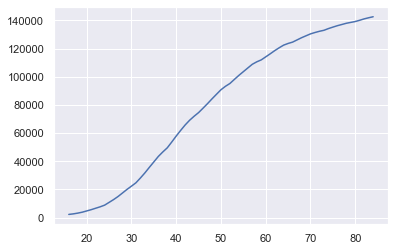

In [181]:
plt.plot(real_cum_cases_ind,real_cum_cases)

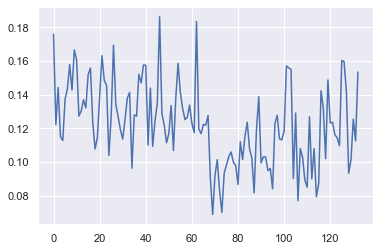

In [182]:
plt.plot(0.12*sigma_adjust2)

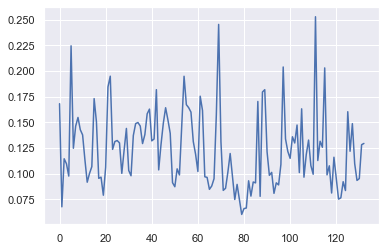

In [183]:
plt.plot(0.12*sigma_adjust2/sigma_adjust1)

In [184]:
data = {"region": region_order,"lr":0.12*sigma_adjust2/sigma_adjust1}

In [185]:
data = pd.DataFrame(data)

In [186]:
data.to_csv("lr.csv",index=False)

In [187]:
death_data = pd.read_csv('../../../data/coronavirus-deaths_0615.csv')

cum_death_number = np.array(death_data[death_data['Area name']=='England'][::-1].iloc[9:]['Cumulative deaths'])

cum_death_number_ind = np.cumsum(np.ones(len(cum_death_number)))+initial_day

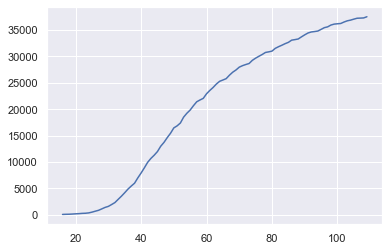

In [188]:
plt.plot(cum_death_number_ind,cum_death_number)

# Initialization

In [189]:
alpha = 0.055 #+ np.random.normal(0, 0.01, 1)[0]
beta = 0.2 #+ np.random.normal(0, 0.05, 1)[0]
gamma = 0.1 #+ np.random.normal(0, 0.02, 1)[0]
kappa = 0.5 # + np.random.normal(0, 0.05, 1)[0]

f0 = 0.002 
f1 = 0.002
f2 = 0.01
f3 = 0.01
f4 = 0.05
f5 = 0.05
f6 = 0.1
f7 = 0.1
f8 =  0.2
f9 = 0.2
f10 = 0.6
f11 = 0.6
f12 = 2.0
f13 = 2.0
f14 = 4.0
f15 = 7.5 

p0 = 0.075 
p1 =  0.075
p2 = 0.05
p3 = 0.05
p4 = 0.15
p5 = 0.15
p6 = 0.21
p7 = 0.21
p8 =  0.23 
p9 = 0.23 
p10 = 0.28
p11 = 0.28
p12 =  0.41
p13 =  0.41
p14 =  0.375
p15 = 0.375
p = [p0,p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
pi = 4.5/100
# 0.005,0.25,2,6
f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi

In [190]:
scale = 0.12

In [191]:
## initial population
init_sick = np.zeros((N_A,N_K))
init_sick_scale = np.zeros((N_A,N_K))
for a in [4,5,6,7,8,9,10,11]:
    init_sick[a,:] = initial_covid*(N_mat[a,:])/np.sum(N_mat[4:12,:],axis=0)

for a in [4,5,6,7,8,9,10,11]:
    init_sick_scale[a,:] = init_sick[a,:]/(p[a]*pi)
#init_sick[1,44] = 5
#init_sick[1,64] = 5
init_vals = N_mat-(init_sick_scale).astype(int),(init_sick_scale).astype(int), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K))

In [192]:
lag = 10

In [193]:
region_population = np.sum(N_mat,axis=0)

# Experiments

In [194]:
sns.set(font_scale=1.3)

In [195]:
threshold1 = 40*56
threshold2 =  0.4*threshold1

In [196]:
thresholds1 = region_population*threshold1/np.sum(region_population)
thresholds2 = region_population*threshold2/np.sum(region_population)

In [197]:
relax = 0.5
control_last = 7
nn = 1000
end = nn+1
stop_bf_last = 2000
S,E,I,A,D,R,C_dynamics,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,thresholds1,thresholds2,relax,control_last,stop_bf_last,nn)



In [198]:
I = np.array(I)
D = np.array(D)

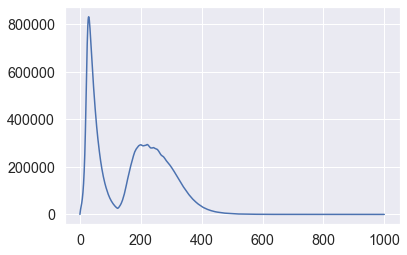

In [199]:
plt.plot(np.sum(I,axis=(1,2)))

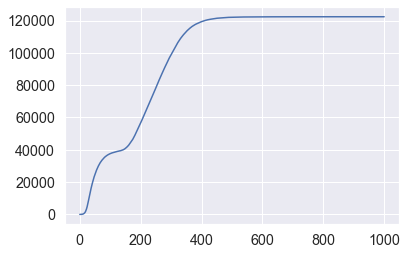

In [200]:
plt.plot(np.sum(D,axis=(1,2)))

In [201]:
np.sum(D,axis=(1,2))[-1]

122336.0

In [202]:
benchmark_total_contact = 0
for r in range(133):
    for a in range(16):
        benchmark_total_contact += N_mat[a,r]*sigma_adjust1[r]*nn*np.sum(Sigma[a,:])

In [203]:
benchmark_total_contact

613800527142.0557

In [204]:
paths = 20
D_ext = np.zeros((paths,nn+1,16,133))
I_ext = np.zeros((paths,nn+1,16,133))
A_ext = np.zeros((paths,nn+1,16,133))
R_ext = np.zeros((paths,nn+1,16,133))
costs = np.zeros(paths)
for path in range(paths):
    print(path)
    np.random.seed(path+100)
    S,E,I,A,D,R,C_dynamics,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,thresholds1,thresholds2,relax,control_last,stop_bf_last,nn)
    lenss = np.array(D).shape[0]
    D_ext[path,:lenss,:,:] = np.array(D)
    D_ext[path,lenss:,:,:] = np.array(D)[-1,:,:]
    R_ext[path,:lenss,:,:] = np.array(R)
    R_ext[path,lenss:,:,:] = np.array(R)[-1,:,:]
    I_ext[path,:lenss,:,:] = np.array(I)
    A_ext[path,:lenss,:,:] = np.array(A)
    costs[path] = benchmark_total_contact - total_contact

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [205]:
D_ext.shape

(20, 1001, 16, 133)

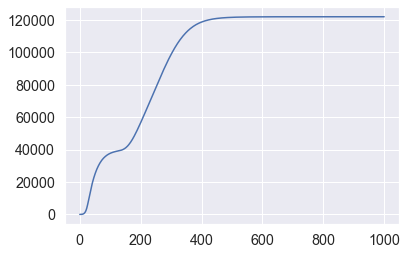

In [206]:
plt.plot(np.sum(np.mean(D_ext,axis=0),axis=(1,2)))

In [207]:
lag=10

In [208]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[155-lag]

40390.59999999999

In [209]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

122066.75

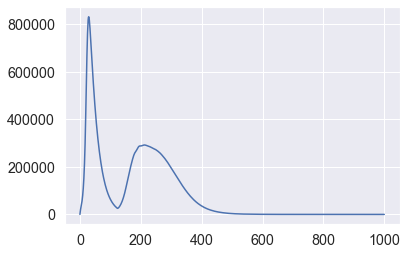

In [210]:
plt.plot(np.sum(np.mean(I_ext,axis=0),axis=(1,2)))

In [211]:
np.sum(np.mean(I_ext,axis=0),axis=(1,2))[155-lag]

80103.6

In [212]:
np.max(np.sum(np.mean(I_ext,axis=0),axis=(1,2))[100:])

292203.85

In [213]:
np.sum(np.mean(A_ext,axis=0),axis=(1,2))[155-lag]

320221.85

In [214]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[155-lag]

40390.59999999999

In [215]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

122066.75

In [216]:
np.max(np.sum(np.mean(A_ext,axis=0),axis=(1,2))[100:])

1115505.5

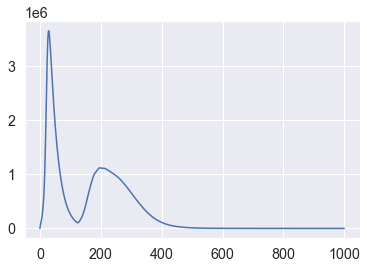

In [217]:
plt.plot(np.sum(np.mean(A_ext,axis=0),axis=(1,2)))

In [218]:
np.argmax(thresholds1)

61

In [219]:
np.mean(costs)

300160323363.048

In [220]:
region = 37

In [221]:
pop_ratio = np.sum(N_mat[:,region])/np.sum(N_mat)

In [222]:
xx = np.cumsum(np.ones(1000))+9

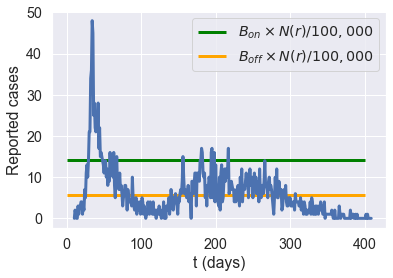

In [223]:
plt.plot(xx[:400],np.sum(regional_confirm_cases[:,:,37],axis=1)[:400],linewidth=3)
plt.hlines(threshold1*pop_ratio, 0,400,color='green',label=r'$B_{on}\times N(r)/100,000$',linewidth=3)
plt.hlines(threshold2*pop_ratio, 0,400,color='orange',label=r'$B_{off}\times N(r)/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/decentralised_reported_leicester.png",bbox_inches="tight")

In [224]:
lockdown_ind = np.array(signals[37,:400]>0)

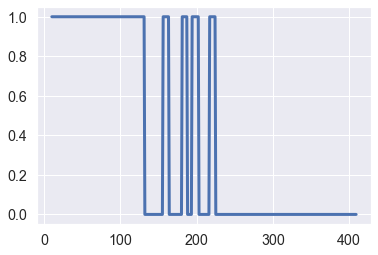

In [225]:
plt.plot(xx[:400],lockdown_ind,linewidth=3)

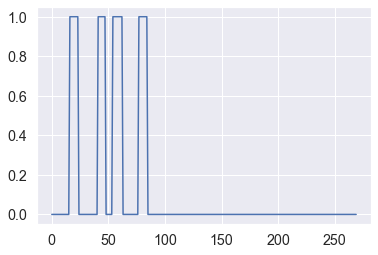

In [226]:
plt.plot(lockdown_ind[130:])

In [227]:
np.sum(lockdown_ind[130:])

32

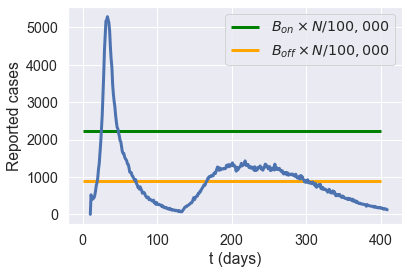

In [228]:
plt.plot(xx[:400],np.sum(england_confirm_cases,axis=1)[:400],linewidth=3)
plt.hlines(threshold1, 0,400,color='green',label=r'$B_{on}\times N/100,000$',linewidth=3)
plt.hlines(threshold2, 0,400,color='orange',label=r'$B_{off}\times N/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/decentralised_reported_england.png",bbox_inches="tight")

In [229]:
np.sum(np.mean(R_ext,axis=0),axis=(1,2))[-1]+np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

41197816.0

In [230]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

122066.75

In [231]:
127/136

0.9338235294117647

In [232]:
np.mean(costs)

300160323363.048

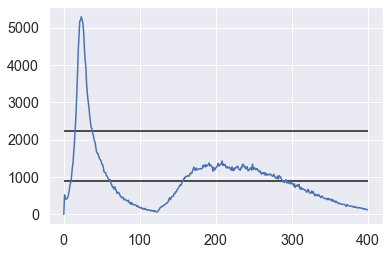

In [233]:
plt.plot(np.sum(england_confirm_cases,axis=1)[:400])
plt.hlines(threshold1, 0,400)
plt.hlines(threshold2, 0,400)

In [234]:
D_ext_region_69 = D_ext[:,:,:,69]
D_ext_region_89 = D_ext[:,:,:,89]
D_ext_region_48 =  D_ext[:,:,:,48]

In [235]:
np.sum(np.mean(D_ext_region_89,axis=0),axis=1)[-1]

1401.6499999999999

In [236]:
np.sum(np.mean(D_ext_region_69,axis=0),axis=1)[-1]

313.8

In [237]:
np.sum(np.mean(D_ext_region_48,axis=0),axis=1)[-1]

2076.8500000000004

In [238]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

122066.75

In [239]:
D_ext_region_80 = D_ext[:,:,:,80]
I_ext_region_80 = I_ext[:,:,:,80]

D_ext_region_20 = D_ext[:,:,:,20]
I_ext_region_20 = I_ext[:,:,:,20]

D_ext_region_24 = D_ext[:,:,:,24]
I_ext_region_24 = I_ext[:,:,:,24]

D_ext_region_48 = D_ext[:,:,:,48]
I_ext_region_48 = I_ext[:,:,:,48]

D_ext_region_69 = D_ext[:,:,:,69]
I_ext_region_69 = I_ext[:,:,:,69]

D_ext_region_89 = D_ext[:,:,:,89]
I_ext_region_89 = I_ext[:,:,:,89]

D_ext_region_37 = D_ext[:,:,:,37]
I_ext_region_37 = I_ext[:,:,:,37]

In [240]:
#feedback_table = pd.read_csv('../data/feedback_40_05R_050_07.csv')
feedback_table = pd.read_csv('data/feedback_40_04R_050_07.csv')

In [241]:
feedback_table.head()

,region_24_I,region_24_D,region_48_I,region_48_D,region_69_I,region_69_D,region_89_I,region_89_D,region_37_I,region_37_D,england_I,england_D
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.3,0.0,249.5,0.0,335.2,0.0,148.5,0.0,30.1,0.0,11716.2,0.0
2,36.0,0.0,416.6,0.0,573.1,0.1,256.8,0.3,49.8,0.0,19954.4,3.1
3,50.4,0.0,586.3,0.1,746.1,0.2,339.9,0.3,70.2,0.0,26744.3,7.9
4,63.0,0.1,753.6,0.4,889.4,0.3,417.9,0.3,92.4,0.0,33272.0,16.6


In [242]:
sns.set(font_scale=1.3)

# England

In [254]:
np.array(feedback_table['england_D'])[-1]

126151.94999999998

In [255]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

114320.4

In [256]:
(np.array(feedback_table['england_D'])[-1] - np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1])/np.array(feedback_table['england_D'])[-1]

0.09378808650995875

(0.0, 135000.0)

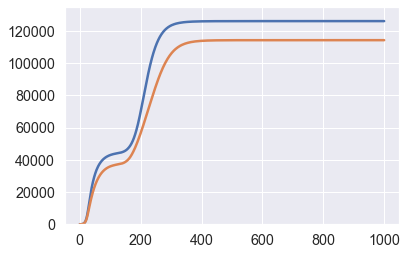

In [258]:
plt.plot(np.array(feedback_table['england_D']),linewidth=2.5)
plt.plot(np.sum(np.mean(D_ext,axis=0),axis=(1,2)),linewidth=2.5)
plt.ylim((0,135000))
#plt.savefig("../results/frontiers/0721/comparison_D_4000_800_0-50_56_lowratio.png",bbox_inches="tight")

In [111]:
data = pd.read_csv('data/openloop_regions.csv')

In [112]:
open_leicester = np.array(data['leicester'])
open_birmingham = np.array(data['birmingham'])

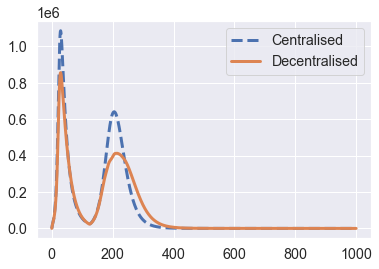

In [261]:
plt.plot(np.array(feedback_table['england_I']),linewidth=3,label='Centralised',linestyle='--')
plt.plot(np.sum(np.mean(I_ext,axis=0),axis=(1,2)),linewidth=3,label='Decentralised')
plt.legend()
plt.savefig("results/comparison_I_4000_800_0-50_56_lowratio.png",bbox_inches="tight")

# Region 24: York

In [262]:
region_order[24]

'UKE21'

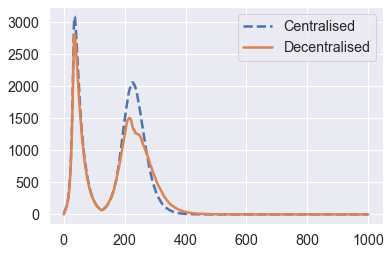

In [263]:
plt.plot(np.array(feedback_table['region_24_I']),linewidth=2.5,label='Centralised',linestyle='--')
plt.plot(np.sum(np.mean(I_ext_region_24,axis=0),axis=1),linewidth=2.5,label='Decentralised')
plt.legend()
plt.savefig("results/region_24_comparison_I_4000_800_0-50_56_lowratio.png")

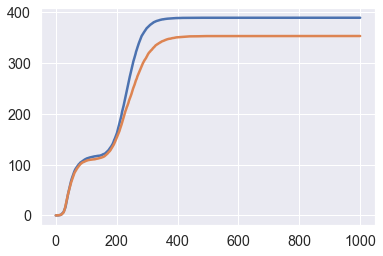

In [264]:
plt.plot(np.array(feedback_table['region_24_D']),linewidth=2.5)
plt.plot(np.sum(np.mean(D_ext_region_24,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0721/region_24_comparison_D_4000_800_0-50_56_lowratio.png")

In [265]:
print(np.array(feedback_table['region_24_D'])[-1],np.sum(np.mean(D_ext_region_24,axis=0),axis=1)[-1])

389.0 353.05000000000007


# Region 48: Birmingham

In [266]:
region_order[48]

'UKG31'

In [267]:
open_birmingham[:120] = np.sum(np.mean(I_ext_region_48,axis=0),axis=1)[:120]
decentralised_birmingham = np.sum(np.mean(I_ext_region_48,axis=0),axis=1)
decentralised_birmingham[:120]= np.array(feedback_table['region_48_I'])[:120]

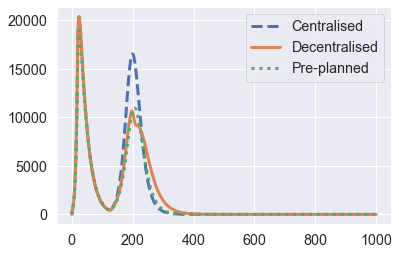

In [268]:
plt.plot(np.array(feedback_table['region_48_I']),linewidth=3,linestyle='--',label='Centralised')
plt.plot(decentralised_birmingham,linewidth=3,label='Decentralised')
plt.plot(open_birmingham,linewidth=3,linestyle=':',label='Pre-planned')
plt.legend()
plt.savefig("results/mega_comparison_birmingham.png")
#plt.savefig("../results/frontiers/0712/region_48_comparison_I_4000_800_0-50_56_lowratio.png")

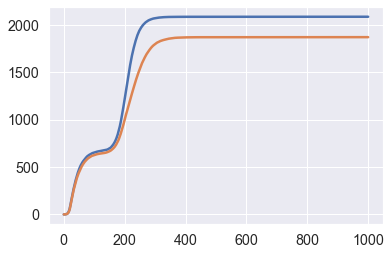

In [269]:
plt.plot(np.array(feedback_table['region_48_D']),linewidth=2.5)
plt.plot(np.sum(np.mean(D_ext_region_48,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0721/region_48_comparison_D_4000_800_0-50_56_lowratio.png")

In [270]:
print(np.array(feedback_table['region_48_D'])[-1],np.sum(np.mean(D_ext_region_48,axis=0),axis=1)[-1])

2083.5 1868.3500000000001


# Region 69: Westminster

In [271]:
region_order[69]

'UKI32'

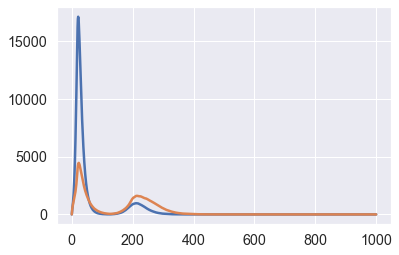

In [272]:
plt.plot(np.array(feedback_table['region_69_I']),linewidth=2.5)
plt.plot(np.sum(np.mean(I_ext_region_69,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0721/region_69_comparison_I_4000_800_0-50_56_lowratio.png")

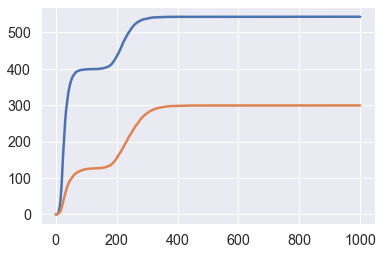

In [273]:
plt.plot(np.array(feedback_table['region_69_D']),linewidth=2.5)
plt.plot(np.sum(np.mean(D_ext_region_69,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0712/region_69_comparison_D_4000_800_0-50_56_lowratio.png")

In [274]:
print(np.array(feedback_table['region_69_D'])[-1],np.sum(np.mean(D_ext_region_69,axis=0),axis=1)[-1])

543.0 299.4


# Region 89: Oxford

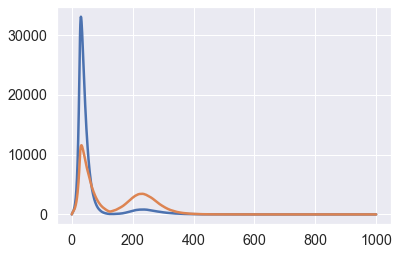

In [275]:
plt.plot(np.array(feedback_table['region_89_I']),linewidth=2.5)
plt.plot(np.sum(np.mean(I_ext_region_89,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0721/region_89_comparison_I_4000_800_0-50_56_lowratio.png")

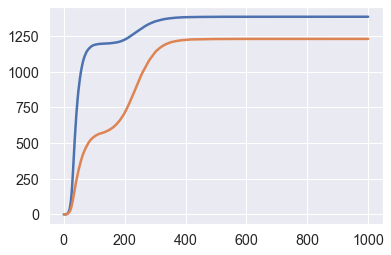

In [276]:
plt.plot(np.array(feedback_table['region_89_D']),linewidth=2.5)
plt.plot(np.sum(np.mean(D_ext_region_89,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0721/region_89_comparison_D_4000_800_0-50_56_lowratio.png")

In [277]:
print(np.array(feedback_table['region_89_D'])[-1],np.sum(np.mean(D_ext_region_89,axis=0),axis=1)[-1])

1385.8 1230.45


# Region 37

In [113]:
open_leicester[:120] = np.sum(np.mean(I_ext_region_37,axis=0),axis=1)[:120]
decentralised_leicester = np.sum(np.mean(I_ext_region_37,axis=0),axis=1)
decentralised_leicester[:120]= np.array(feedback_table['region_37_I'])[:120]

NameError: name 'feedback_table' is not defined

In [ ]:
plt.plot(np.array(feedback_table['region_37_I']),linewidth=3,label='Centralised',linestyle='--')
plt.plot(decentralised_leicester,linewidth=3,label='Decentralised')
plt.plot(open_leicester,linewidth=3,label='Pre-planned',linestyle=':')
plt.legend()
#plt.savefig("../results/frontiers/0730/region_37_comparison_I_4000_800_0-50_56_lowratio.png")
plt.savefig("results/mega_comparison_leicester.png")

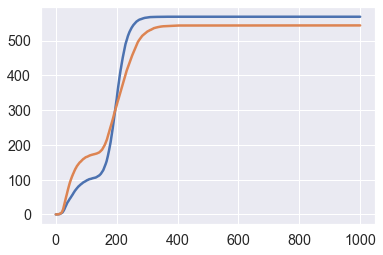

In [280]:
plt.plot(np.array(feedback_table['region_37_D']),linewidth=2.5)
plt.plot(np.sum(np.mean(D_ext_region_37,axis=0),axis=1),linewidth=2.5)
#plt.savefig("../results/frontiers/0721/region_37_comparison_D_4000_800_0-50_56_lowratio.png")

In [281]:
print(np.array(feedback_table['region_37_D'])[-1],np.sum(np.mean(D_ext_region_37,axis=0),axis=1)[-1])

568.75 543.8000000000001


In [282]:
decentralised_leicester = np.sum(np.mean(I_ext_region_37,axis=0),axis=1)
decentralised_leicester[:120]= np.array(feedback_table['region_37_I'])[:120]

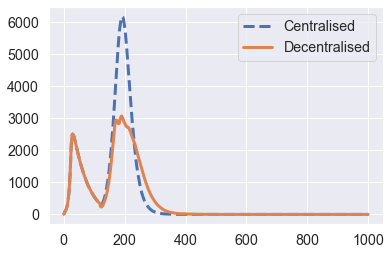

In [283]:
plt.plot(np.array(feedback_table['region_37_I']),linewidth=3,label='Centralised',linestyle='--')
plt.plot(decentralised_leicester,linewidth=3,label='Decentralised')
plt.legend()

# Death Visualization

In [ ]:
total_death_rgs = np.zeros(133)

In [ ]:
for i in range(133):
    total_death_rgs[i] = np.sum(np.mean(D_ext[:,:,:,i],axis=0),axis=1)[-1]

In [ ]:
region_death = pd.read_csv('data/death_visualziation_60_04R_040_07.csv')

In [ ]:
region_death.head()

In [ ]:
region_death['death_region'] = total_death_rgs

In [ ]:
np.max(np.array((region_death['death_countrywide'] - region_death['death_region'])/region_death['death_countrywide']))

In [ ]:
index = np.array((region_death['death_countrywide'] - region_death['death_region'])/region_death['death_countrywide'])>0.20

In [ ]:
index * (np.cumsum(np.ones(133))-1)

In [ ]:
np.argmax(np.array((region_death['death_countrywide'] - region_death['death_region'])/region_death['death_countrywide']))

In [ ]:
_,_,_ = plt.hist(region_death['death_countrywide'] - region_death['death_region'])

In [ ]:
region_death.to_csv('data/death_visualziation_final_60_04R_040_07.csv',index=False)